# Confronto: insertion-sort vs counting-sort

Notebook pratico che confronta le prestazioni di insertion-sort e counting-sort su array di interi. Le celle alternano brevi spiegazioni (markdown) e codice eseguibile.

## Import e impostazioni
Impostiamo l'ambiente: seed riproducibile e stile per i grafici.

In [1]:
from numpy import sort
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
RNG = np.random.default_rng(42)
plt.style.use('seaborn-v0_8-whitegrid')

## Insertion sort
Implementazione semplice (opera su una copia). Complessità: O(n^2).

In [2]:
def insertion_sort(a):
    """Ordina `a` e ritorna una nuova lista ordinata.
    Non modifica l'input."""
    if isinstance(a, np.ndarray):
        arr = a.tolist()
    else:
        arr = list(a)
    n = len(arr)
    for i in range(1, n):
        key = arr[i]
        j = i - 1
        while j >= 0 and arr[j] > key:
            arr[j+1] = arr[j]
            j -= 1
        arr[j+1] = key
    return arr

### Teoria: insertion-sort
Insertion sort è un algoritmo di ordinamento basato su confronti che può essere implementato in-place o ritornando una nuova lista.
Funzionamento: si costruisce progressivamente una porzione iniziale dell'array che è sempre ordinata; ad ogni passo si inserisce il prossimo elemento nella sua posizione corretta all'interno della porzione ordinata.

Complessità
- Caso migliore: O(n) (array già ordinato)
- Caso medio: O(n^2)
- Caso peggiore: O(n^2) (array in ordine inverso)
- Spazio addizionale: O(1) per versione in-place

Esempio rapido di `insertion_sort`.

In [3]:
sample = RNG.integers(0, 50, size=12)
print('sample:', sample)
print('insertion_sort result:', insertion_sort(sample))

sample: [ 4 38 32 21 21 42  4 34 10  4 26 48]
insertion_sort result: [4, 4, 4, 10, 21, 21, 26, 32, 34, 38, 42, 48]


## Counting sort
Counting sort per interi non negativi. Complessità: O(n + k).

In [4]:
def counting_sort(a):
    """Counting sort classico che calcola internamente il valore massimo.
    - Accetta liste o numpy array.
    - Supporta solo interi non negativi.
    - Solleva ValueError per valori negativi e MemoryError se k (max+1) è troppo grande.
    """
    if isinstance(a, np.ndarray):
        arr = a.tolist()
    else:
        arr = list(a)
    if not arr:
        return []
    # Verifica che non ci siano valori negativi
    if min(arr) < 0:
        raise ValueError('Counting sort: supporta solo interi non negativi')
    # calcolo diretto del massimo
    max_value = max(arr)
    k = max_value + 1
    # limite di sicurezza per evitare OOM accidentali
    MAX_K_LIMIT = 50_000_000
    if k > MAX_K_LIMIT:
        raise MemoryError(f'k troppo grande per il counting sort: k={k} > {MAX_K_LIMIT}')
    counts = [0] * k
    for v in arr:
        counts[v] += 1
    out = []
    for val, c in enumerate(counts):
        if c:
            out.extend([val] * c)
    return out

### Teoria: counting-sort e varianti
- **Complessità temporale**:
  - O(n + k) in tutti i casi (migliore, medio e peggiore)
  - Non dipende dall'ordine iniziale degli elementi
  - La complessità lineare O(n) è raggiungibile solo quando k = O(n)
- **Complessità spaziale**:
  - O(n + k) totale: O(n) per l'output e O(k) per l'array di conteggio
  - Il fattore dominante è max(n, k)
  - Per k >> n diventa inefficiente in termini di memoria
- **Caratteristiche**:
  - Non basato su confronti (comparison-free)
  - Stabile nella versione con array cumulativo (non quella implementata)
  - Limitato a interi o valori mappabili a interi in un range limitato
- **Trade-off**:
  - Ottimo quando k è piccolo rispetto a n
  - Inefficiente quando k >> n (per memoria e tempo)

Esempio rapido di `counting_sort`.

In [5]:
print('counting_sort result (sample):', counting_sort(sample))

counting_sort result (sample): [4, 4, 4, 10, 21, 21, 26, 32, 34, 38, 42, 48]


## Test di correttezza
Verifica su casi semplici e edge case.

In [6]:
def is_sorted(a):
    return all(a[i] <= a[i+1] for i in range(len(a)-1))

# più test, includendo casi con ripetizioni e range piccoli/grandi
tests = [[], [1], [2,1], [5,3,8,1,2,7], list(RNG.integers(0,50,size=20)), [0,0,0,0], list(range(10,0,-1))]
for t in tests:
    res_i = insertion_sort(t)
    res_c = counting_sort(t)
    assert is_sorted(res_i)
    assert is_sorted(res_c)
    assert sorted(list(t)) == res_i == res_c
print('Tutti i test di correttezza passati.')

Tutti i test di correttezza passati.


## Benchmark: tempo e memoria
Misuriamo tempo medio (con deviazione) e picco di memoria Python allocata (usando tracemalloc).
Eseguiamo test su diverse combinazioni di n (dimensione) e k (massimo valore possibile)


Per valutare le prestazioni degli algoritmi di ordinamento, è necessario generare una lista di valori interi di dimensione n e misurare il tempo di esecuzione di ambedue gli algoritmi.
risulta anche utile un confronto della memoria utilizzata data la natura del countinsort

Per ottenere una valutazione accurata dell' Insertion Sort, verranno creati dati per il caso randomico che ha la stessa complessità del caso peggiore, e dati per il caso migliore. Invece, per il counting sort, ciò non è necessario, in quanto questi particolari dati non influiscono sulle sue prestazioni, poiché la sua complessità rimane costante in tutti i casi. I test di ordinamento verranno eseguiti su un insieme di n valori, con n che varia da 1 a 10000.


In [7]:
import tracemalloc
import math
import copy
import time

"""def test_algorithm(algo, data, repeat=5, warm=True):
    times = []
    peaks = []
    data_copy = copy.deepcopy(data)
    if warm:
        try:
            algo(data_copy)
        except Exception:
            pass
    for _ in range(repeat):
        tracemalloc.start()
        t0 = time.perf_counter()
        exc = None
        try:
            algo(data_copy)
        except Exception as e:
            exc = e
        t1 = time.perf_counter()
        try:
            _, peak = tracemalloc.get_traced_memory()
        except Exception:
            peak = 0
        tracemalloc.stop()
        if exc is not None:
            times.append(math.nan)
            peaks.append(math.nan)
        else:
            times.append(t1 - t0)
            peaks.append(float(peak))

    return {
        'raw_times': times,
        'raw_peaks': peaks,
    }
"""
def test_time_algorithm(algo, size, repeat=5, k = None, flag = False):
    times = []
    data = data_generator(size, k)

    for _ in range(repeat):

        data = data_generator(size, k)
        if flag:
            data = sort(data)
        t0 = time.perf_counter()
        exc = None
        try:
            algo(data)
        except Exception as e:
            exc = e
        t1 = time.perf_counter()

        if exc is not None:
            times.append(math.nan)
        else:

            times.append(t1 - t0)
    time_np = np.array(times)
    mean = np.mean(time_np)
    std = np.std(time_np)
    return mean, std

la funzione di test valuta l'algoritmo selezionato su una copia di un array di dati e ripete il test {repeat} volte per ridurre il rumore

In [8]:

def data_generator(size,k):
    return RNG.integers(1, k + 1, size=size, dtype=int)

import os
os.makedirs('noteBookPng', exist_ok=True)

def plot_results_fixed_k_vary_n(sizes: list,times_insertion, times_counting, flag_k = False
                                , name: str = 'random', flag = False):
    """
    Crea 3 grafici:
    1. Insertion Sort con linea asintotica O(n²)
    2. Counting Sort con linea asintotica O(n + k)
    3. Confronto combinato
    """
    x = np.array(sizes, dtype=float)

    ins_mean = np.array(times_insertion['mean'], dtype=float)
    ins_std = np.array(times_insertion['std'], dtype=float)
    cnt_mean = np.array(times_counting['mean'], dtype=float)
    cnt_std = np.array(times_counting['std'], dtype=float)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, ins_mean, 'o-', label='Insertion Sort (misurato)',
            color='tab:blue', linewidth=2, markersize=6)

    ax.fill_between(x, ins_mean - ins_std, ins_mean + ins_std,
                     color='tab:blue', alpha=0.2)
    if flag:
        asymptotic_insertion = x / np.max(x) * np.max(ins_mean)
        ax.plot(x, asymptotic_insertion, '--', label='O(n) asintotico',
            color='red', linewidth=2, alpha=0.7)
    else:
        asymptotic_insertion = (x ** 2) / np.max(x ** 2) * np.max(ins_mean)
        ax.plot(x, asymptotic_insertion, '--', label='O(n²) asintotico',
            color='red', linewidth=2, alpha=0.7)
    if not flag_k:
        ax.set_xlabel('Dimensione dell\'array (n)', fontsize=12)
        ax.set_ylabel('Tempo di esecuzione (s)', fontsize=12)
        ax.set_title('Insertion Sort - Analisi Temporale', fontsize=14, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(fontsize=11, loc='upper left')
        ax.set_ylim(bottom=0)

        plt.tight_layout()
        plt.savefig(f'noteBookPng/insertion_sort_analysis_{name}.png', dpi=150)
        print("✓ Salvato: insertion_sort_analysis.png")
    else:
        ax.set_xlabel('Dimensione dell\'array (n)', fontsize=12)
        ax.set_ylabel('Tempo di esecuzione (s)', fontsize=12)
        ax.set_title('Insertion Sort con k >> n - Analisi Temporale', fontsize=14, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(fontsize=11, loc='upper left')
        ax.set_ylim(bottom=0)
        plt.tight_layout()
        plt.savefig(f'noteBookPng/insertion_sort_analysis_k_large_{name}.png', dpi=150)
        print("✓ Salvato: insertion_sort_analysis_k_large.png")

    plt.show()
    plt.close()

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot dei dati
    ax.plot(x, cnt_mean, 's-', label='Counting Sort (misurato)',
            color='tab:green', linewidth=2, markersize=6)
    ax.fill_between(x, cnt_mean - cnt_std, cnt_mean + cnt_std,
                     color='tab:green', alpha=0.2)

    # Linea asintotica O(n)
    asymptotic_counting = x / np.max(x) * np.max(cnt_mean)
    ax.plot(x, asymptotic_counting, '--', label='O(n) asintotico',
            color='red', linewidth=2, alpha=0.7)
    if not flag_k:
        ax.set_xlabel('Dimensione dell\'array (n)', fontsize=12)
        ax.set_ylabel('Tempo di esecuzione (s)', fontsize=12)
        ax.set_title('Counting Sort - Analisi Temporale', fontsize=14, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(fontsize=11, loc='upper left')
        ax.set_ylim(bottom=0)

        plt.tight_layout()
        plt.savefig(f'noteBookPng/counting_sort_analysis_{name}.png', dpi=150)
        print("✓ Salvato: counting_sort_analysis.png")
    else:
        ax.set_xlabel('Dimensione dell\'array (n)', fontsize=12)
        ax.set_ylabel('Tempo di esecuzione (s)', fontsize=12)
        ax.set_title('Counting Sort con k >> n - Analisi Temporale', fontsize= 14, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(fontsize=11, loc='upper left')
        ax.set_ylim(bottom=0)
        plt.tight_layout()
        plt.savefig(f'noteBookPng/counting_sort_analysis_k_large_{name}.png', dpi=150)
        print("✓ Salvato: counting_sort_analysis_k_large.png")


    plt.show()
    plt.close()

    # ===== Grafico 3: Confronto combinato =====
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot Insertion Sort
    ax.plot(x, ins_mean, 'o-', label='Insertion Sort',
            color='tab:blue', linewidth=2.5, markersize=7)
    ax.fill_between(x, ins_mean - ins_std, ins_mean + ins_std,
                     color='tab:blue', alpha=0.15)

    # Linea asintotica Insertion Sort

    # Plot Counting Sort
    ax.plot(x, cnt_mean, 's-', label='Counting Sort',
            color='tab:green', linewidth=2.5, markersize=7)
    ax.fill_between(x, cnt_mean - cnt_std, cnt_mean + cnt_std,
                     color='tab:green', alpha=0.15)

    # Linea asintotica Counting Sort

    k_values = x * 5000  # k dipende da n
    X = x + k_values
    # X = x + 5000

    # protezioni: divisione per zero
    max_X = np.max(X)

    max_cnt = np.max(cnt_mean) if cnt_mean.size > 0 else 0.0
    if max_X == 0 or max_cnt == 0:
        asymptotic_counting = np.zeros_like(x)
    else:
        scale = max_cnt / max_X
        asymptotic_counting = X * scale

    ax.plot(x, asymptotic_counting, '--', label=f'O(n + k) asintotico (k=size*5000)',
            color='red', linewidth=2, alpha=0.7)

    # ax.plot(x, asymptotic_counting, '--', label='O(n) asintotico', color='darkgreen', linewidth=2, alpha=0.6)
    if not flag_k:
        ax.set_xlabel('Dimensione dell\'array (n)', fontsize=12)
        ax.set_ylabel('Tempo di esecuzione (s)', fontsize=12)
        ax.set_title('Confronto: Insertion Sort vs Counting Sort', fontsize=14, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(fontsize=11, loc='upper left', ncol=2)
        ax.set_ylim(bottom=0)

        plt.tight_layout()
        plt.savefig(f'noteBookPng/sorting_comparison_{name}.png', dpi=150)
        print("✓ Salvato: sorting_comparison.png")
    else:
        ax.set_xlabel('Dimensione dell\'array (n)', fontsize=12)
        ax.set_ylabel('Tempo di esecuzione (s)', fontsize=12)
        ax.set_title('Confronto con k >> n: Insertion Sort vs Counting Sort', fontsize=14, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(fontsize=11, loc='upper left', ncol=2)
        ax.set_ylim(bottom=0)
        plt.tight_layout()
        plt.savefig(f'noteBookPng/sorting_comparison_k_large_{name}.png', dpi=150)
        print("✓ Salvato: sorting_comparison_k_large.png")
    plt.show()
    plt.close()





i: 10
i: 22
i: 46
i: 100
i: 215
i: 464
i: 1000
i: 2154
i: 4642
i: 10000
✓ Salvato: insertion_sort_analysis.png


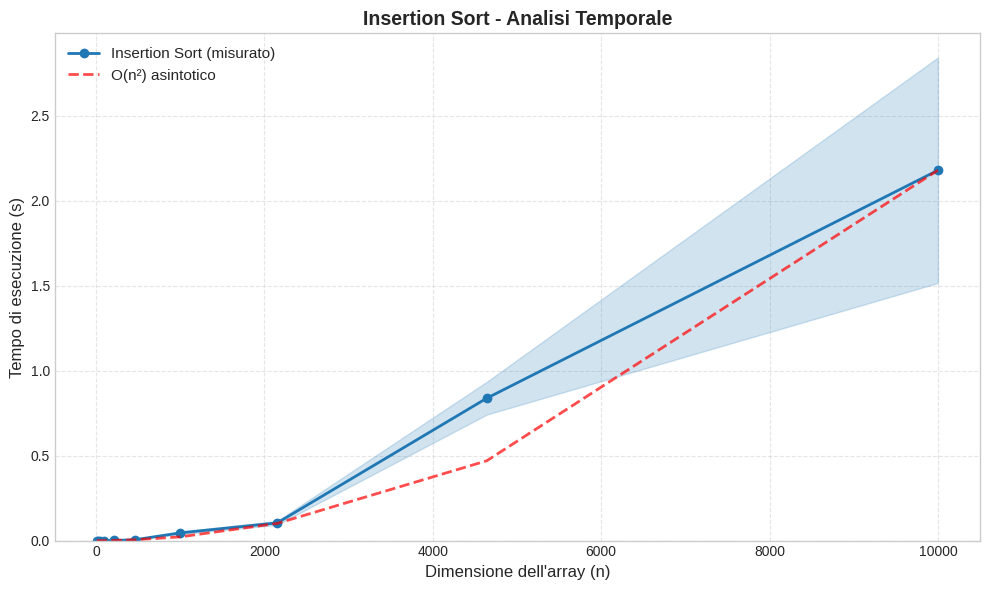

✓ Salvato: counting_sort_analysis.png


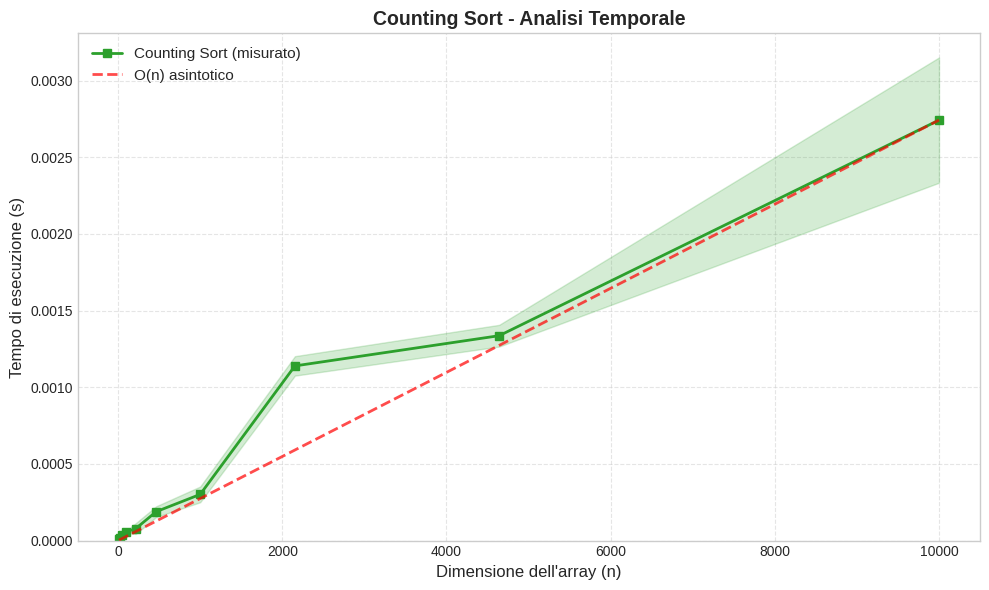

✓ Salvato: sorting_comparison.png


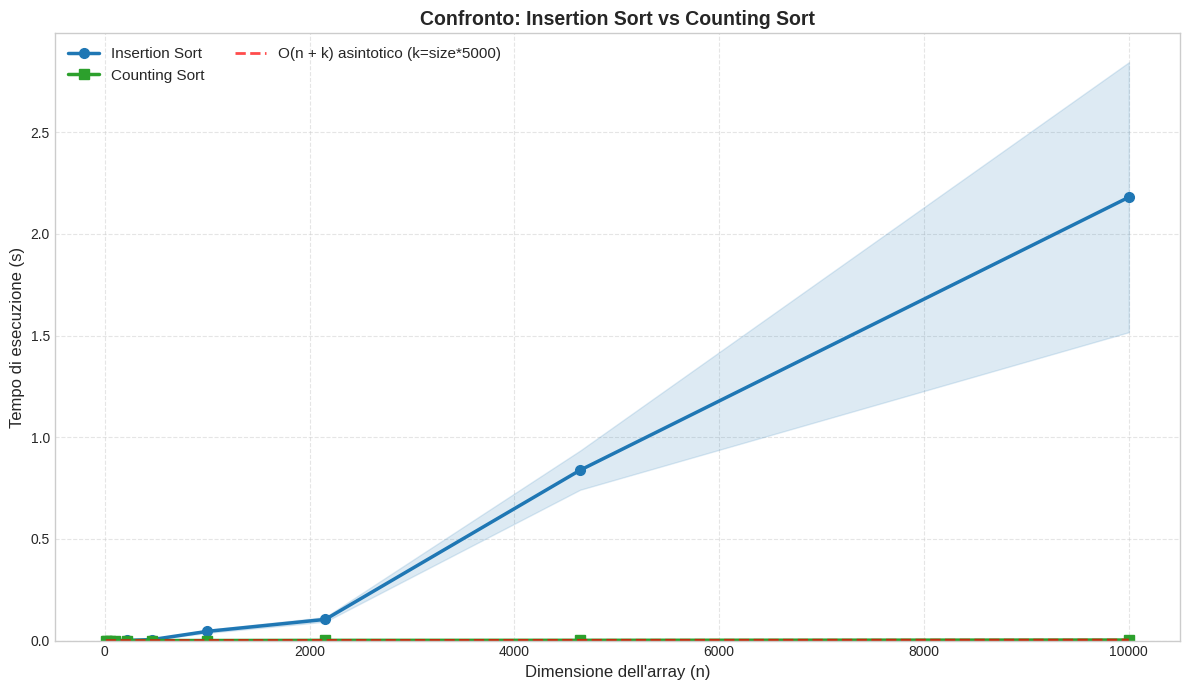

size: 10
size: 22
size: 46
size: 100
size: 215
size: 464
size: 1000
size: 2154
size: 4642
size: 10000


In [9]:
sizes = np.unique(np.round(np.logspace(1, 4, 10)).astype(int))

insertion_sort_mean =[]
insertion_sort_std =[]
counting_sort_mean =[]
counting_sort_std =[]
for i in sizes:
    print('i:', i)
    temp_mean, temp_std = test_time_algorithm(insertion_sort,size=i,k = i)
    insertion_sort_mean.append(temp_mean)
    insertion_sort_std.append(temp_std)
    temp_mean, temp_std = test_time_algorithm(counting_sort,size=i,k = i)
    counting_sort_mean.append(temp_mean)
    counting_sort_std.append(temp_std)

result= {
    'selectionSort1': {
        'mean': insertion_sort_mean,
        'std': insertion_sort_std
    },
    'countingSort1': {
        'mean': counting_sort_mean,
        'std': counting_sort_std
    }
}
plot_results_fixed_k_vary_n(sizes= sizes ,times_insertion=result['selectionSort1'], times_counting=result['countingSort1'], name = 'random')
#clear generale
insertion_sort_mean.clear()
insertion_sort_std.clear()
counting_sort_mean.clear()
counting_sort_std.clear()

#test con k molto grande rispetto a n riusando vecchie strutture
for size in sizes:
    print('size:', size)
    temp_mean, temp_std = test_time_algorithm(insertion_sort,size=size, k=size*5000)
    insertion_sort_mean.append(temp_mean)
    insertion_sort_std.append(temp_std)
    temp_mean, temp_std = test_time_algorithm(counting_sort,size=size, k=size*5000)
    counting_sort_mean.append(temp_mean)
    counting_sort_std.append(temp_std)
result= {
    'selectionSort1': {
        'mean': insertion_sort_mean,
        'std': insertion_sort_std
    },
    'countingSort1': {
        'mean': counting_sort_mean,
        'std': counting_sort_std
    }
}






# plot_side_by_side(sizes= sizes ,insertion_times=result['selectionSort1'], counting_times=result['countingSort1'])

✓ Salvato: insertion_sort_analysis_k_large.png


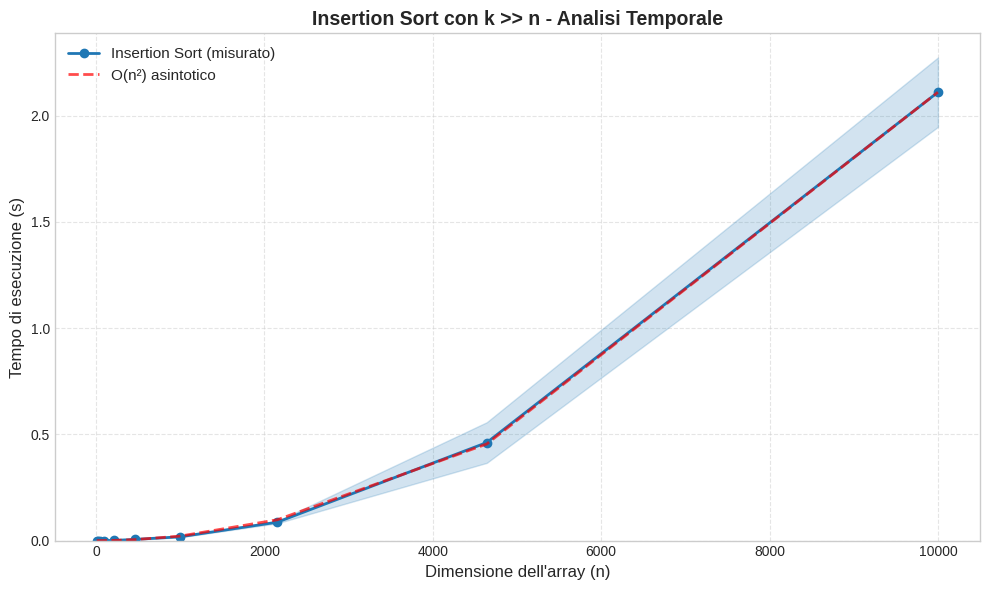

✓ Salvato: counting_sort_analysis_k_large.png


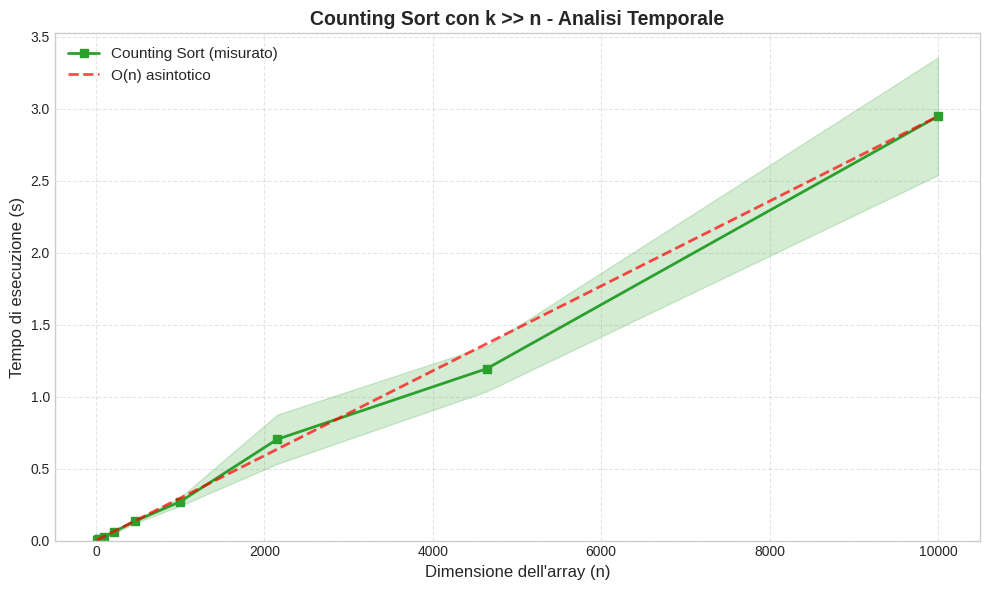

✓ Salvato: sorting_comparison_k_large.png


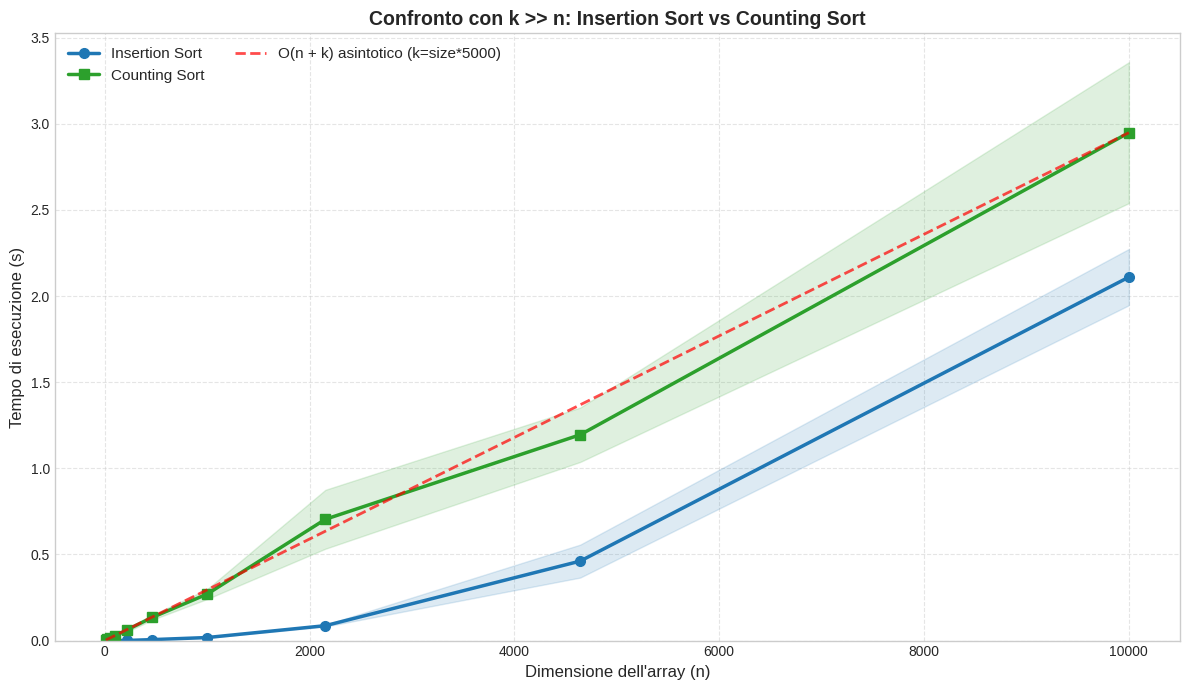

In [10]:
plot_results_fixed_k_vary_n(sizes= sizes ,times_insertion=result['selectionSort1'], times_counting=result['countingSort1'], flag_k=True, name = 'random')

size: 10
size: 22
size: 46
size: 100
size: 215
size: 464
size: 1000
size: 2154
size: 4642
size: 10000
✓ Salvato: insertion_sort_analysis.png


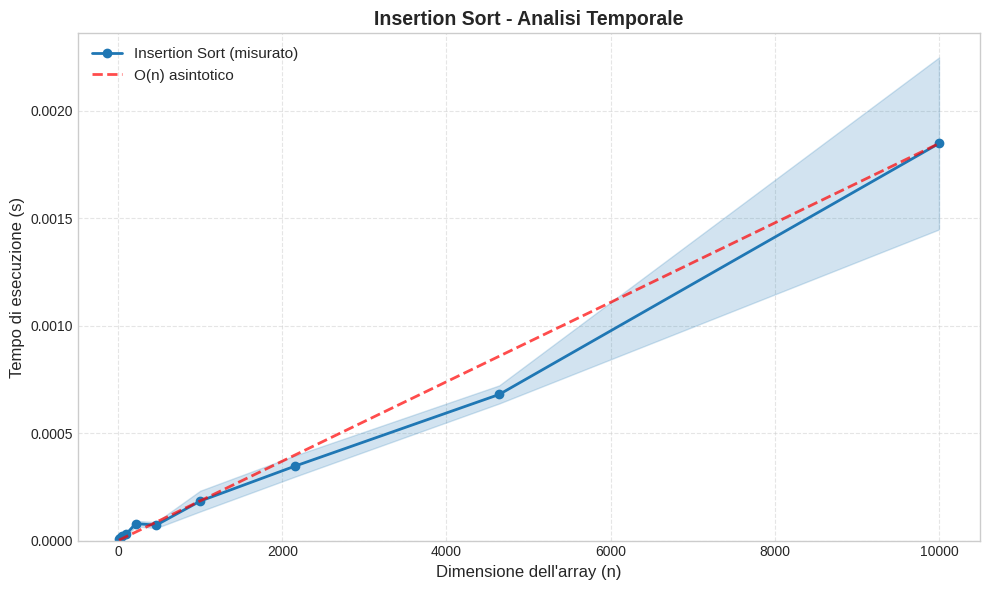

✓ Salvato: counting_sort_analysis.png


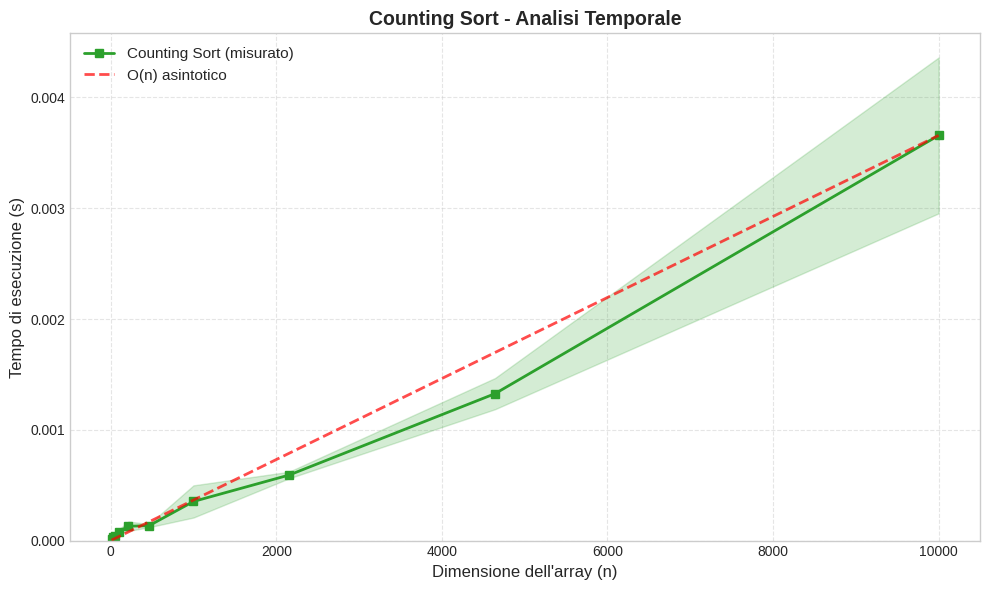

✓ Salvato: sorting_comparison.png


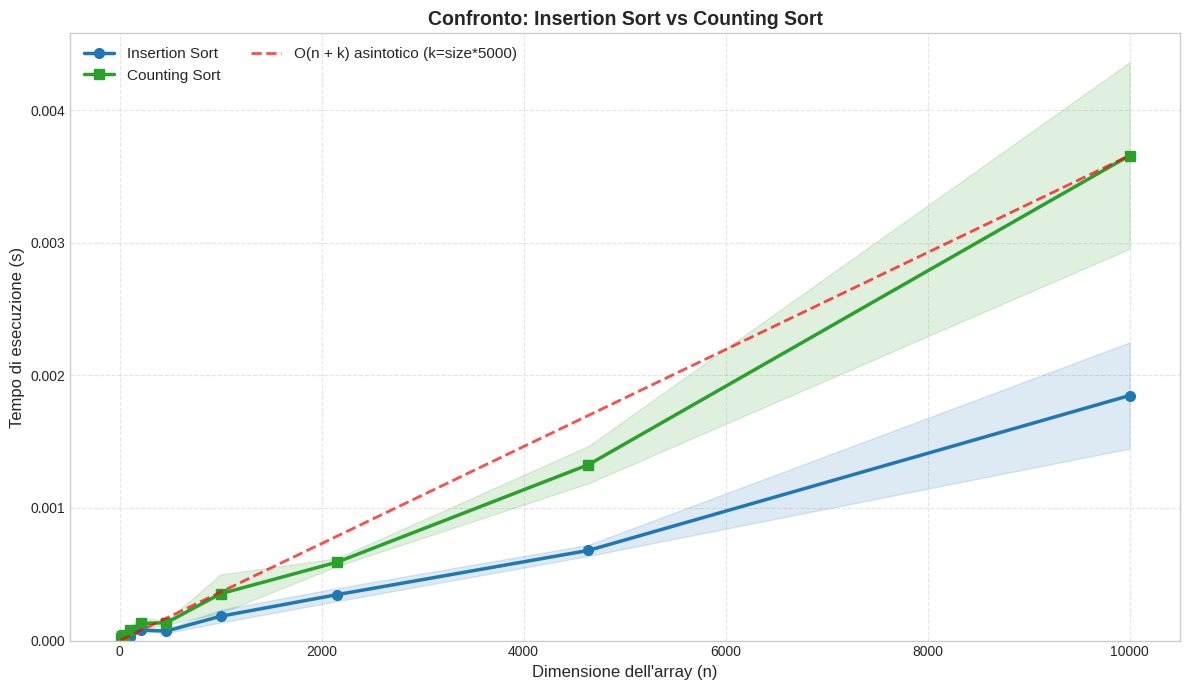

In [11]:
insertion_sort_mean.clear()
insertion_sort_std.clear()
counting_sort_mean.clear()
counting_sort_std.clear()
for size in sizes:
    print('size:', size)
    temp_mean, temp_std = test_time_algorithm(insertion_sort,size=size, k=size, flag=True)
    insertion_sort_mean.append(temp_mean)
    insertion_sort_std.append(temp_std)
    temp_mean, temp_std = test_time_algorithm(counting_sort,size=size, k=size, flag=True)
    counting_sort_mean.append(temp_mean)
    counting_sort_std.append(temp_std)


result= {
    'selectionSort1': {
        'mean': insertion_sort_mean,
        'std': insertion_sort_std
    },
    'countingSort1': {
        'mean': counting_sort_mean,
        'std': counting_sort_std
    }
}

plot_results_fixed_k_vary_n(sizes= sizes ,times_insertion=result['selectionSort1'], times_counting=result['countingSort1'], flag_k=False, name = 'best_case', flag = True)



spiegare la differenza dei coefficenti

## Visualizzazione grafici
mostrare le figure
### Confronto per k=n


### Confronto per k= 5000*n



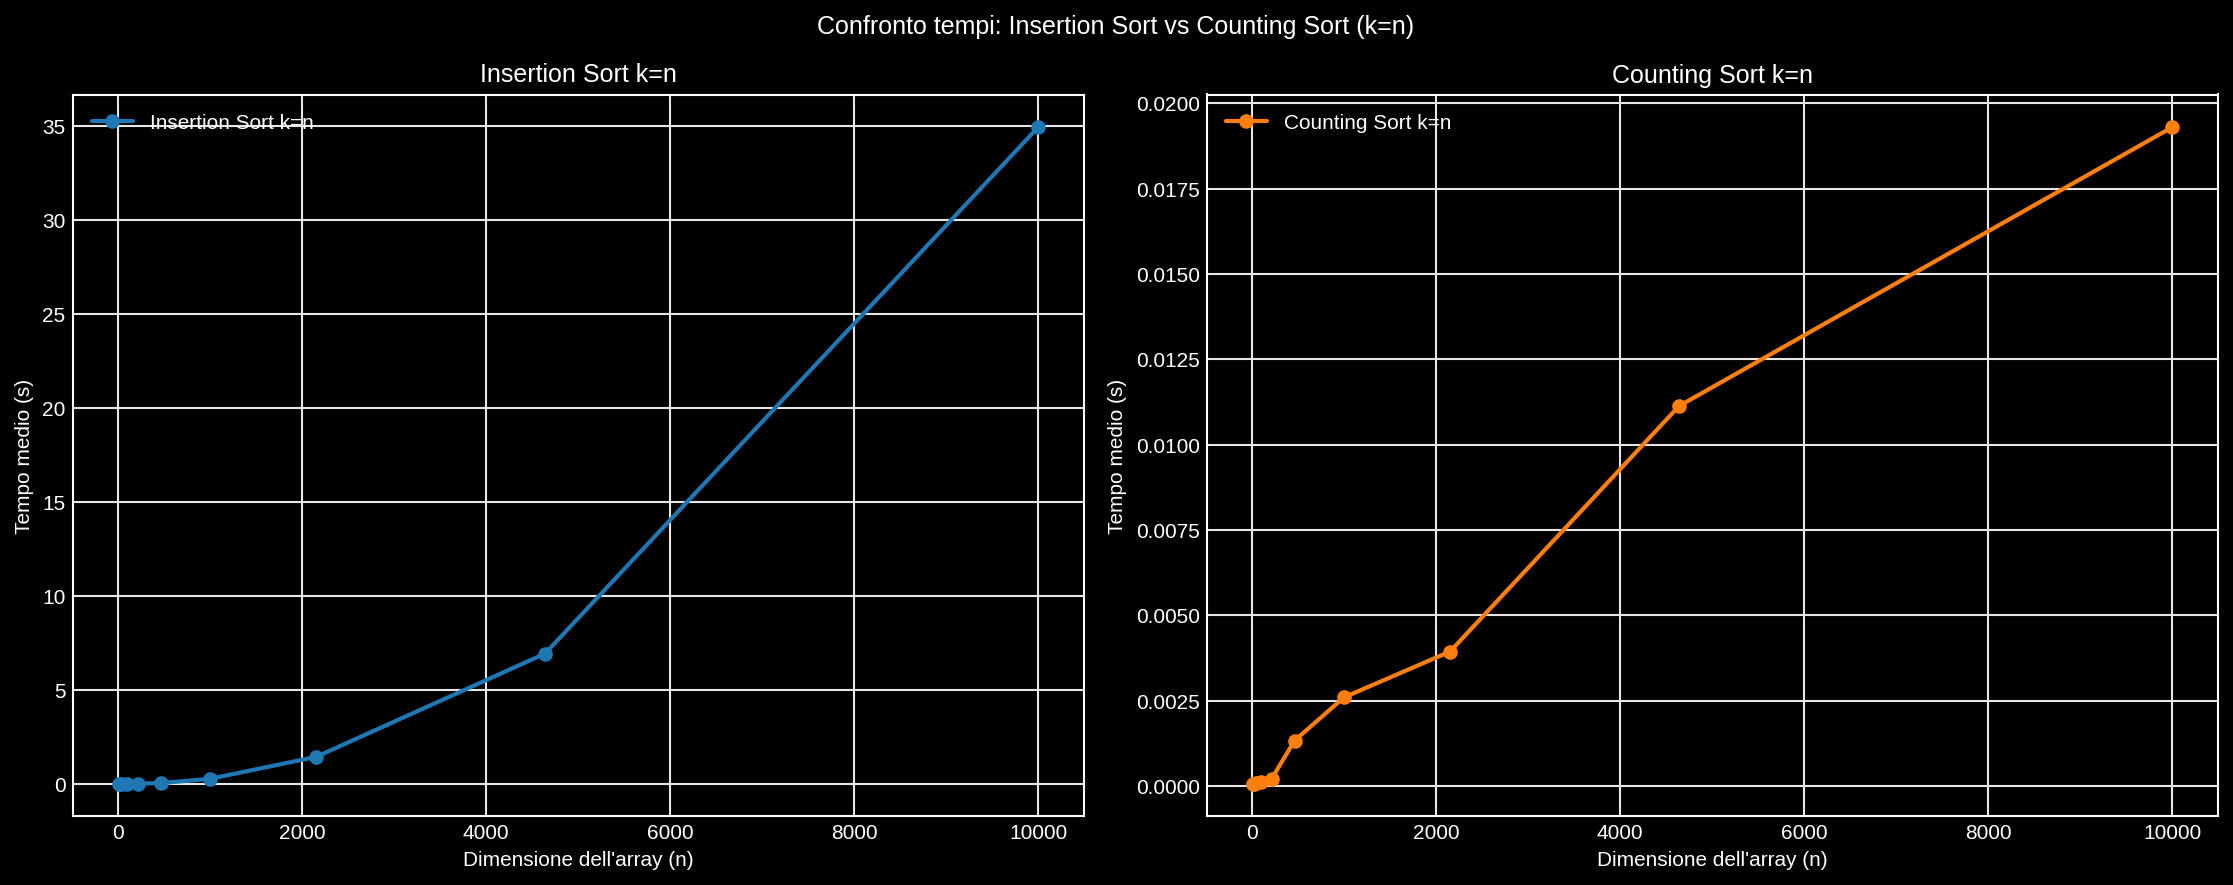
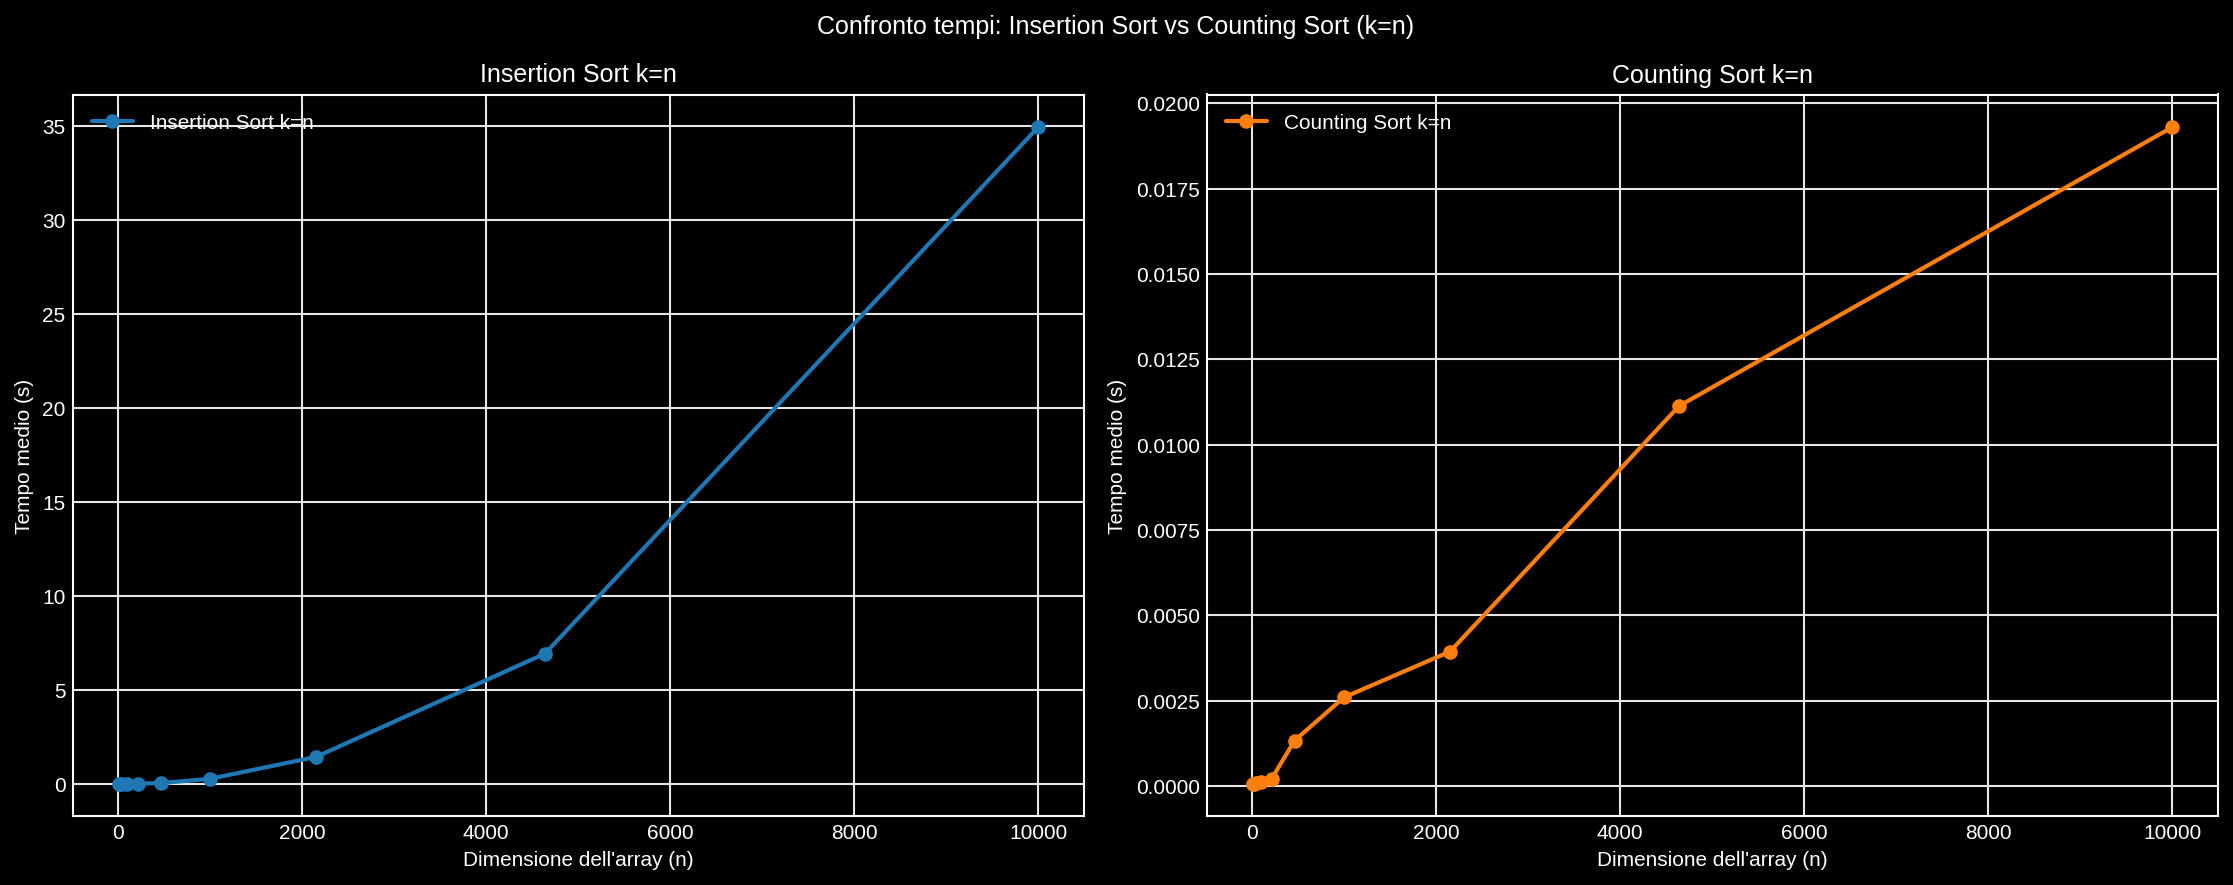
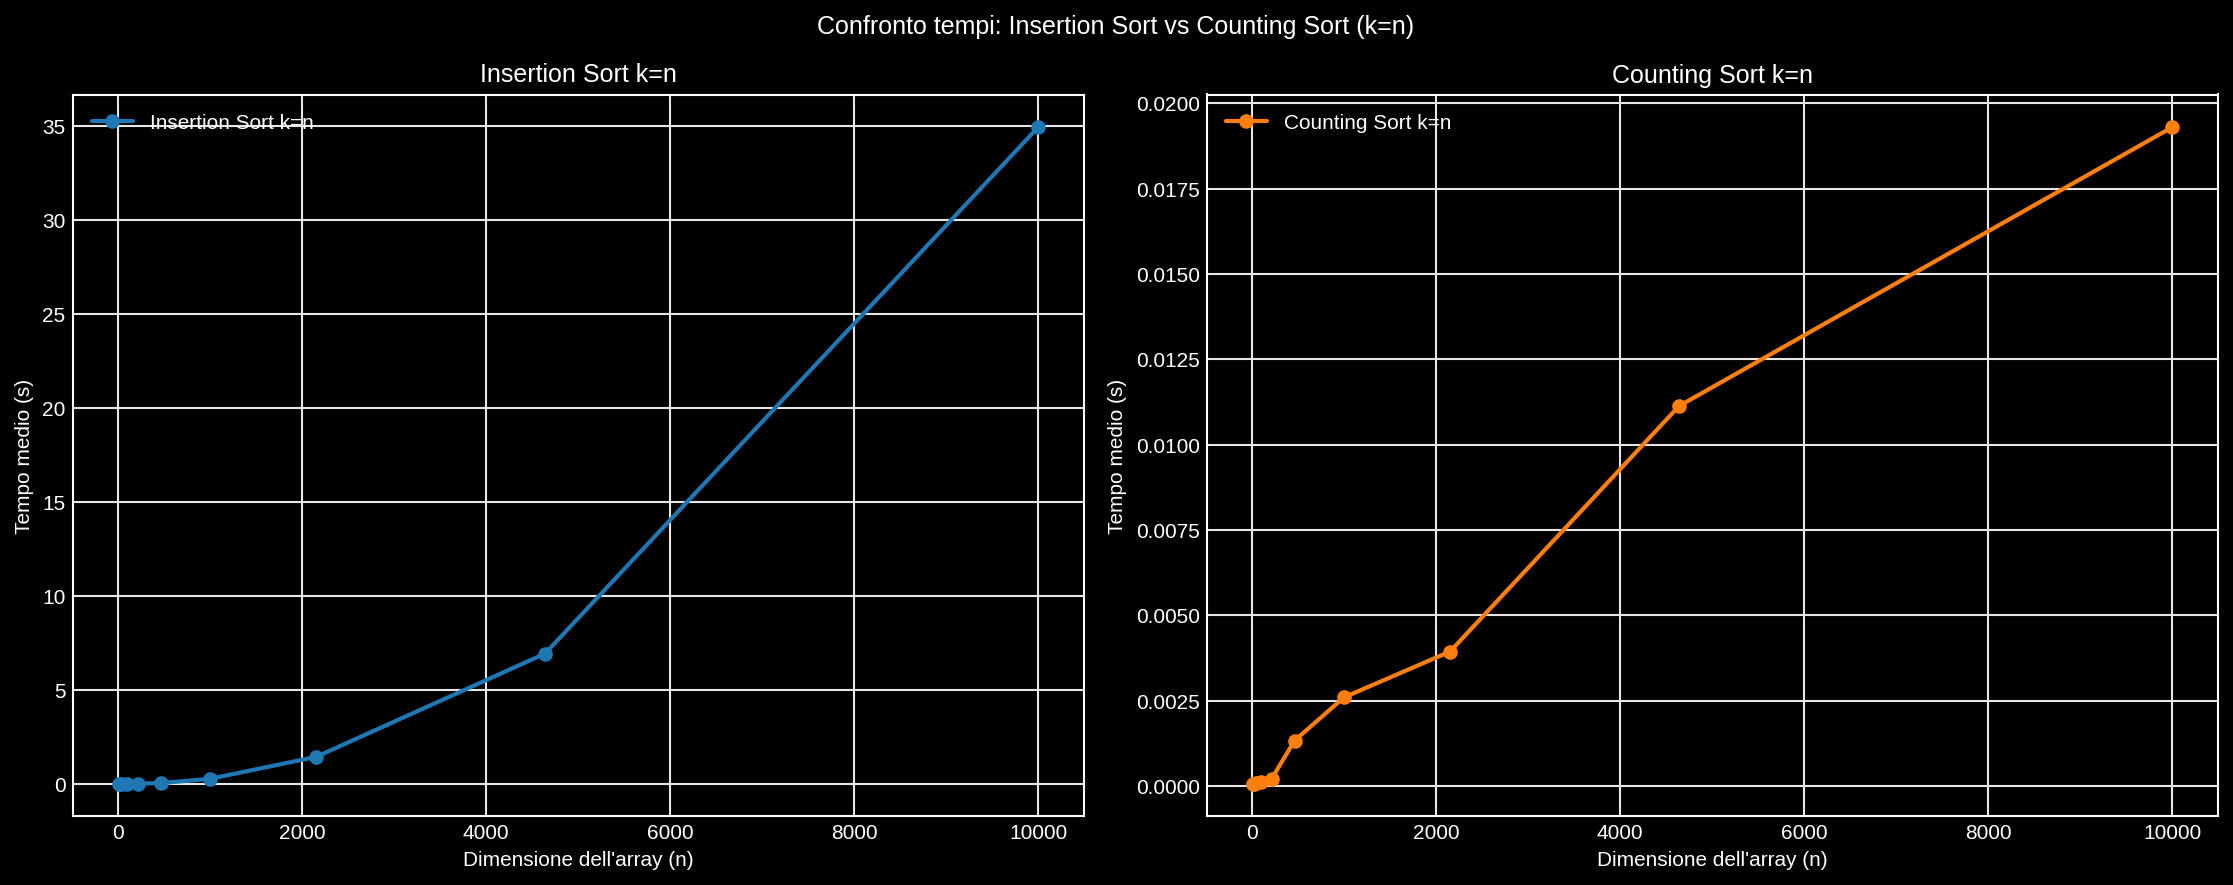

## Teoria: benchmarking e misurazioni


- **Perché il warmup**:
  - Negli ambienti Python, la prima esecuzione di una funzione è spesso più lenta (compilazione JIT, cache, ottimizzazioni interne)
  - Il warmup prepara l'interprete e le strutture dati interne per misurazioni più stabili
  - Neutralizza effetti come: inizializzazione lazy, compilazione JIT (per PyPy), ottimizzazioni del GC, ecc.
  - In questo esperimento, eseguiamo insertion_sort e counting_sort su un array di test prima di iniziare le misurazioni reali

- **Metodologia di misurazione**:
  - Ripetizione multipla: ogni misura è ripetuta 5 volte per ottenere valori statisticamente significativi usando set di dati differenti
  - Calcolo di media e deviazione standard: per valutare sia le prestazioni tipiche che la loro variabilità
  - Misurazioni separate per tempo e memoria: entrambe le risorse sono critiche nella valutazione degli algoritmi

- **Considerazioni sull'overhead**:
  - I valori assoluti possono variare tra diverse esecuzioni, ma le tendenze relative sono generalmente consistenti
  - Calcolo di media e deviazione standard: per valutare sia le prestazioni tipiche che la loro variabilità
## Conclusioni: analisi comparativa e risorse utilizzate

### Complessità teorica
- **Insertion sort**:
  - Tempo: O(n²) in generale, O(n) nel caso migliore (array già ordinato)
  - Spazio: O(1) addizionale per la versione in-place

- **Counting sort**:
  - Tempo: O(n + k) in tutti i casi
  - Spazio: O(n + k) totale, con O(k) per l'array di conteggio

### Osservazioni empiriche
- **Risorse temporali**:
  - L'insertion sort diventa rapidamente inefficiente al crescere di n (confermando la complessità quadratica)
  - Il counting sort mantiene prestazioni lineari quando k è contenuto
  - Per k molto grande rispetto a n, il counting sort perde il suo vantaggio competitivo

- **Risorse di memoria**:
  - L'insertion sort ha un consumo di memoria proporzionale alla dimensione dell'input (O(n))
  - Il counting sort richiede memoria aggiuntiva significativa per l'array dei conteggi (O(k))
  - Per valori di k molto grandi (k >> n), il counting sort può diventare proibitivo in termini di memoria
- **Counting sort**:
- **Considerazioni sulla distribuzione dei dati**:
### Applicazioni pratiche
- **Quando usare insertion sort**:
  - Array piccoli (n < 10-20)
  - Array quasi ordinati
  - Quando la memoria è una risorsa critica
  - Come parte di algoritmi ibridi (es. per piccoli sottoinsiemi)

- **Quando usare counting sort**:
  - Range di valori limitato e noto (k = O(n))
  - Grandi dataset con valori ripetuti in un intervallo ristretto
  - Quando la velocità è prioritaria rispetto alla memoria
  - Come componente di algoritmi più sofisticati (es. radix sort)

In conclusione, la scelta tra insertion sort e counting sort dipende criticamente dal rapporto tra n (dimensione dell'input) e k (range dei valori), oltre che dalle risorse di sistema disponibili e dai requisiti dell'applicazione.
